In [44]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [45]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

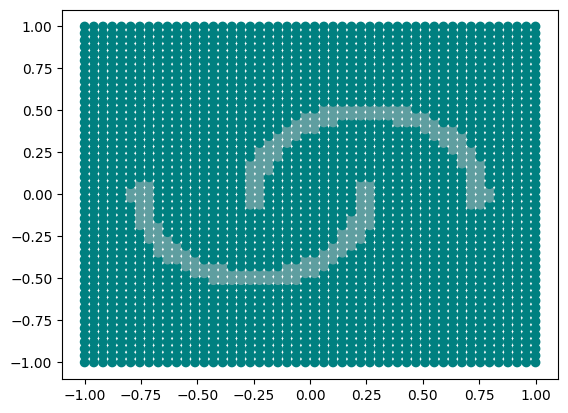

In [46]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()


colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [47]:
def random_sample(X,Y,size=5):
    ind_zeros=np.array([k for k in range(len(X)) if Y[k]==0])
    ind_ones=np.array([k for k in range(len(X)) if Y[k]==1])
    return np.concatenate((np.random.choice(ind_zeros,size=size),np.random.choice(ind_ones,size=size)))

In [54]:
def layer_stiffness(epochs,learning_rate,batch_size,hidden_sizes,init=False):
    model = NeuralNet(2,hidden_sizes,2)
    ReLU_glorot_init(model)

    def next_batch(inputs, targets, batchSize):
        for i in range(0, inputs.shape[0], batchSize):
            yield (inputs[i:i + batchSize], targets[i:i + batchSize])

    opt = SGD(model.parameters(), lr=learning_rate)
    lossFunc = nn.CrossEntropyLoss()

    def training():
        trainLoss = 0
        samples = 0
        model.train()
        for batchX, batchY in next_batch(X, Y, batch_size):
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
            samples += len(batchY)
            trainLoss += loss.item()*len(batchY)
        return trainLoss/samples

    def get_dots():
        N_h=len(model.hidden)
        grads_input_layer=[]
        grads_hidden_layers=[[] for n in range(N_h)]
        grads_output_layer=[]

        for x,y in zip(X,Y):
            predictions = model(x)
            loss = lossFunc(predictions, y.long())
            opt.zero_grad()
            loss.backward()

            gradient_input_layer=[]
            gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient_input_layer+=model.input_layer.bias.grad.tolist()
            gradient_input_layer=np.array(gradient_input_layer)
            if np.linalg.norm(gradient_input_layer)!=0:
                grads_input_layer.append(gradient_input_layer/np.linalg.norm(gradient_input_layer))
            else:
                grads_input_layer.append(gradient_input_layer)

            for k,h_layer in enumerate(model.hidden):
                gradient=[]
                gradient+=torch.flatten(h_layer.weight.grad).tolist()
                gradient+=h_layer.bias.grad.tolist()
                gradient=np.array(gradient)
                if np.linalg.norm(gradient)!=0:
                    grads_hidden_layers[k].append(gradient/np.linalg.norm(gradient))
                else:
                    grads_hidden_layers[k].append(gradient)

            gradient_output_layer=[]
            gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient_output_layer+=model.output_layer.bias.grad.tolist()
            gradient_output_layer=np.array(gradient_output_layer)
            if np.linalg.norm(gradient_output_layer)!=0:
                grads_output_layer.append(gradient_output_layer/np.linalg.norm(gradient_output_layer))
            else:
                grads_output_layer.append(gradient_output_layer)

        dot_matrix_input_layer=[]
        dot_matrix_hidden_layers=[[] for n in range(N_h)]
        dot_matrix_output_layer=[]
        for i in range(len(X)):
            avg_dot_input=0
            avg_dot_hidden=np.zeros(N_h)
            avg_dot_output=0
            samples=0
            sample_ind=random_sample(X,Y)
            for j in sample_ind:        
                avg_dot_input+=np.dot(grads_input_layer[i],grads_input_layer[j])
                for k in range(N_h):
                    avg_dot_hidden[k]+=np.dot(grads_hidden_layers[k][i],grads_hidden_layers[k][j])
                avg_dot_output+=np.dot(grads_output_layer[i],grads_output_layer[j])
                samples+=1
            
            dot_matrix_input_layer.append(avg_dot_input/samples)
            for k,avg_dot in enumerate(avg_dot_hidden):
                dot_matrix_hidden_layers[k].append(avg_dot/samples)
            dot_matrix_output_layer.append(avg_dot_output/samples)
    
        return dot_matrix_input_layer, dot_matrix_hidden_layers, dot_matrix_output_layer
    if init:
        init_input_matrix,init_hidden_matrices,init_output_matrix=get_dots()
    for n in range(epochs):
        l=training()
        print('Epoch {}: Loss {:.3f}'.format(n+1,l))
        if l<0.01:
            break
    input_matrix,hidden_matrix,output_matrix=get_dots()
    if init:
        return init_input_matrix,init_hidden_matrices,init_output_matrix,input_matrix,hidden_matrix,output_matrix
    return input_matrix,hidden_matrix,output_matrix

In [55]:
hidden_layers=[[64,8,4],[8,64,8],[64,8,64]]

dot_matrices=[]

for hidden_layer in hidden_layers:
    D_1,D_2,D_3=layer_stiffness(1000,0.05,100,hidden_layer,False)
    dot_matrices.append([D_1,D_2,D_3])

Epoch 1: Loss 0.488
Epoch 2: Loss 0.322
Epoch 3: Loss 0.284
Epoch 4: Loss 0.275
Epoch 5: Loss 0.272
Epoch 6: Loss 0.271
Epoch 7: Loss 0.270
Epoch 8: Loss 0.270
Epoch 9: Loss 0.269
Epoch 10: Loss 0.269
Epoch 11: Loss 0.268
Epoch 12: Loss 0.268
Epoch 13: Loss 0.267
Epoch 14: Loss 0.267
Epoch 15: Loss 0.266
Epoch 16: Loss 0.266
Epoch 17: Loss 0.265
Epoch 18: Loss 0.265
Epoch 19: Loss 0.264
Epoch 20: Loss 0.263
Epoch 21: Loss 0.263
Epoch 22: Loss 0.262
Epoch 23: Loss 0.261
Epoch 24: Loss 0.261
Epoch 25: Loss 0.260
Epoch 26: Loss 0.259
Epoch 27: Loss 0.258
Epoch 28: Loss 0.258
Epoch 29: Loss 0.257
Epoch 30: Loss 0.256
Epoch 31: Loss 0.255
Epoch 32: Loss 0.254
Epoch 33: Loss 0.253
Epoch 34: Loss 0.253
Epoch 35: Loss 0.252
Epoch 36: Loss 0.251
Epoch 37: Loss 0.250
Epoch 38: Loss 0.249
Epoch 39: Loss 0.248
Epoch 40: Loss 0.247
Epoch 41: Loss 0.246
Epoch 42: Loss 0.245
Epoch 43: Loss 0.244
Epoch 44: Loss 0.243
Epoch 45: Loss 0.243
Epoch 46: Loss 0.242
Epoch 47: Loss 0.241
Epoch 48: Loss 0.240
E

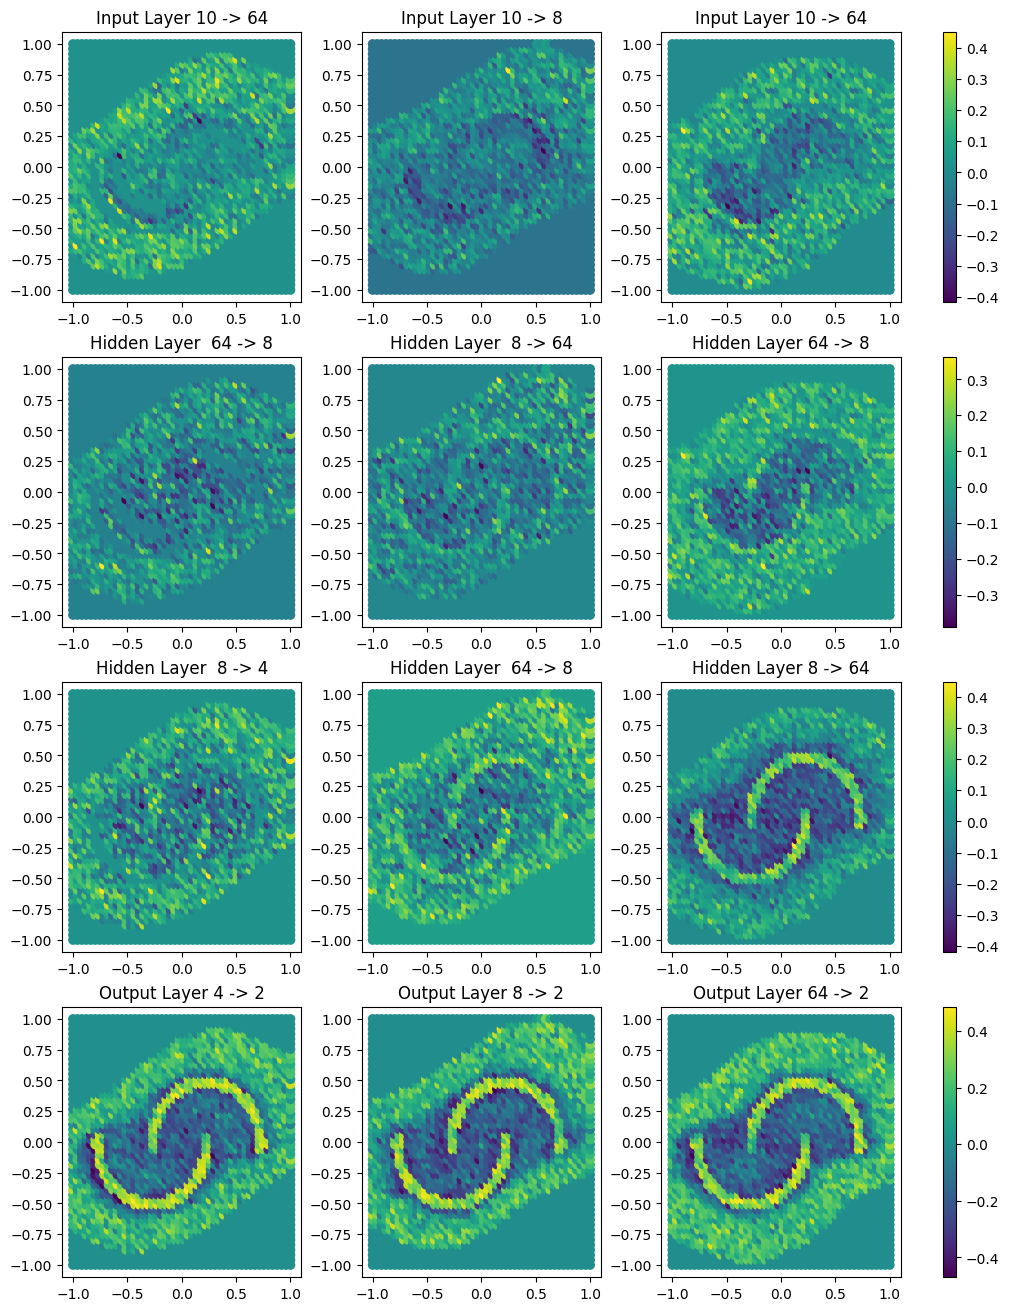

In [62]:
fig, axs = plt.subplots(4,3,figsize=(10,13),layout='constrained')

for k in range(3):
    if k==2:
        pcm = axs[0,k].scatter(X[:,0], X[:,1],c=dot_matrices[k][0])
        axs[0,k].set_title('Input Layer {} -> {}'.format(10,hidden_layers[k][0]))

        fig.colorbar(pcm, ax=axs[0])
    else:
        axs[0,k].scatter(X[:,0], X[:,1],c=dot_matrices[k][0])
        axs[0,k].set_title('Input Layer {} -> {}'.format(10,hidden_layers[k][0]))

    if k==2:
        for n, matrix in enumerate(dot_matrices[k][1]):
            pcm = axs[1+n,k].scatter(X[:,0], X[:,1],c=matrix)
            axs[1+n,k].set_title('Hidden Layer {} -> {}'.format(hidden_layers[k][n],hidden_layers[k][n+1]))

            fig.colorbar(pcm, ax=axs[1+n])
    else:
        for n, matrix in enumerate(dot_matrices[k][1]):
            axs[1+n,k].scatter(X[:,0], X[:,1],c=matrix)
            axs[1+n,k].set_title('Hidden Layer  {} -> {}'.format(hidden_layers[k][n],hidden_layers[k][n+1]))

    if k==2:
        pcm = axs[-1,k].scatter(X[:,0], X[:,1],c=dot_matrices[k][-1])
        axs[-1,k].set_title('Output Layer {} -> {}'.format(hidden_layers[k][-1],2))

        fig.colorbar(pcm, ax=axs[-1])
    else:
        axs[-1,k].scatter(X[:,0], X[:,1],c=dot_matrices[k][-1])
        axs[-1,k].set_title('Output Layer {} -> {}'.format(hidden_layers[k][-1],2))

plt.savefig('plots/Stiffness_for_different_layers.png')